## Natural Language Autocomplete

In this notebook, we're going to use transformers to get autocomplete suggestions for a given term.

In [1]:
import sys
sys.path.append('..')
from aips import *

In [2]:
import pandas
import pickle
import json
import tqdm
pandas.set_option('display.max_rows', 1000)

## Load and clean the Outdoors dataset

In [3]:
#outdoors
![ ! -d 'outdoors' ] && git clone --depth=1 https://github.com/ai-powered-search/outdoors.git
! cd outdoors && git pull
! cd outdoors && cat outdoors.tgz.part* > outdoors.tgz
! cd outdoors && mkdir -p '../../data/outdoors/' && tar -xvf outdoors.tgz -C '../../data/outdoors/'

Already up to date.
README.md
concepts.pickle
._guesses.csv
guesses.csv
._guesses_all.json
guesses_all.json
outdoors_concepts.pickle
outdoors_embeddings.pickle
._outdoors_golden_answers.csv
outdoors_golden_answers.csv
._outdoors_golden_answers.xlsx
outdoors_golden_answers.xlsx
._outdoors_golden_answers_20210130.csv
outdoors_golden_answers_20210130.csv
outdoors_labels.pickle
outdoors_question_answering_contexts.json
outdoors_questionanswering_test_set.json
outdoors_questionanswering_train_set.json
._posts.csv
posts.csv
predicates.pickle
pull_aips_dependency.py
._question-answer-seed-contexts.csv
question-answer-seed-contexts.csv
question-answer-squad2-guesses.csv
._roberta-base-squad2-outdoors
roberta-base-squad2-outdoors/
roberta-base-squad2-outdoors/._tokenizer_config.json
roberta-base-squad2-outdoors/tokenizer_config.json
roberta-base-squad2-outdoors/._special_tokens_map.json
roberta-base-squad2-outdoors/special_tokens_map.json
roberta-base-squad2-outdoors/._config.json
roberta-base-

In [4]:
from densevectors.outdoors import *
#Transform the the outdoors/posts.csv file into a useable dataframe
outdoors_dataframe = cleanDataset('../data/outdoors/posts.csv')
print(len(outdoors_dataframe))

19585


## Make a vocabulary of all the concepts in a corpus

In [5]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_sm')

## Listing 13.8

In [6]:
def normalize(span):
    #normalizes a noun or verb phrase
    return ' '.join([tok.lemma_.lower() for tok in span])

def yieldTuple(df,column,total=100):
    #yields a spacy nlp.pipe compliant tuple of the column text values and its dataframe row as the context
    for idx,row in df.iterrows():
        if idx<total:
            yield (row[column],idx)

def getConcepts(df,total=None,load_from_cache=True):

    if load_from_cache:
        with open('../data/outdoors/outdoors_concepts.pickle','rb') as fd:
            concepts = pickle.load(fd)
        with open('../data/outdoors/outdoors_labels.pickle','rb') as fd:
            labels = pickle.load(fd)
        return concepts,labels

    #Setting load_from_cache to False will bring you here
    print('Extracting concepts. This could take a while. Take a break and stretch :)')
    
    #You can limit the number of rows processed by passing in total (an integer)
    if not total:
        total = len(df)
        
    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept
    
    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ['NN','NNP','NNS','NOUN'] #Nouns
    verbtags = ['VB','VBD','VBG','VBN','VBP','VBZ','VERB'] #Verbs
    matcher.add("noun_phrases", [[{"TAG":{"IN": nountags}, "IS_ALPHA": True,"OP":"+"}]])
    matcher.add("verb_phrases", [[{"TAG":{"IN": verbtags}, "IS_ALPHA": True,"OP":"+", "LEMMA":{"NOT_IN":["be"]}}]])
    for doc,idx in tqdm.tqdm(nlp.pipe(yieldTuple(df,"body",total=total), batch_size=40, n_threads=4, as_tuples=True),total=total):
        text = doc.text
        matches = matcher(doc)
        for matchid,start,end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)
            
    
    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i in range(len(phrases)):
        phrase = phrases[i]
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1
    
    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}
    
    with open('../data/outdoors/outdoors_concepts.pickle','wb') as fd:
        pickle.dump(sorted_concepts,fd)
    with open('../data/outdoors/outdoors_labels.pickle','wb') as fd:
        pickle.dump(labels,fd)
    
    return sorted_concepts,labels

## Listing 13.9

### Examining the vocabulary

What are the concepts with the highest frequency?

In [7]:
# Set load_from_cache=False to re-extract all the concepts from the corpus.
concepts,labels = getConcepts(outdoors_dataframe,load_from_cache=True)
topcons = {k:v for (k,v) in concepts.items() if v>5 }
print('Total number of labels:',len(labels.keys()))
print('Total number of concepts:',len(concepts.keys()))
print('Concepts with greater than 5 term frequency:',len(topcons.keys()))
print(json.dumps(topcons,indent=2))

Total number of labels: 124366
Total number of concepts: 124366
Concepts with greater than 5 term frequency: 12375
{
  "have": 32782,
  "do": 26869,
  "use": 16793,
  "get": 13412,
  "go": 9899,
  "water": 9537,
  "make": 9476,
  "need": 7814,
  "time": 7187,
  "take": 6550,
  "find": 6359,
  "see": 5591,
  "rope": 5540,
  "know": 5522,
  "day": 5318,
  "way": 5239,
  "want": 5087,
  "people": 5083,
  "keep": 4789,
  "look": 4784,
  "area": 4548,
  "work": 4491,
  "thing": 4451,
  "try": 4179,
  "tent": 4095,
  "bag": 4054,
  "lot": 3934,
  "think": 3728,
  "trail": 3725,
  "say": 3669,
  "foot": 3606,
  "climb": 3559,
  "point": 3550,
  "place": 3539,
  "question": 3424,
  "help": 3206,
  "come": 3186,
  "put": 3115,
  "hike": 3042,
  "weight": 3034,
  "fall": 3027,
  "start": 3009,
  "leave": 2977,
  "answer": 2949,
  "give": 2945,
  "something": 2926,
  "food": 2907,
  "year": 2864,
  "carry": 2823,
  "pack": 2755,
  "end": 2752,
  "one": 2741,
  "bear": 2738,
  "fire": 2730,
  "bod

## Transformer time!

In [8]:
from sentence_transformers import SentenceTransformer, util as STutil
stsb = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

## Listing 13.10

In [9]:
def getEmbeddings(concepts,minimum_frequency,load_from_cache=True):
    phrases = [key for (key,tf) in concepts.items() if tf>=minimum_frequency]
    if not load_from_cache:
        embeddings = stsb.encode(phrases, convert_to_tensor=True)
        with open('../data/outdoors/outdoors_embeddings.pickle','wb') as fd:
            pickle.dump(embeddings,fd)
    else:
        with open('../data/outdoors/outdoors_embeddings.pickle','rb') as fd:
            embeddings = pickle.load(fd)
    return phrases,embeddings

#Note!  This is a hyperparameter.
#We are ignoring terms that occur less than this numner in the entire corpus.
#Lowering this number may lower precision
#Raising this number may lower recall
minimum_frequency = 6

#set load_from_cache=False to regenerate the embeddings rather than loading from pickle
phrases,embeddings = getEmbeddings(concepts,minimum_frequency, load_from_cache=True)

print('Number of embeddings:',len(embeddings))
print('Dimensions per embedding:',len(embeddings[0]))

Number of embeddings: 12375
Dimensions per embedding: 768


## Listing 13.11

### Explore the top similarities for the top terms

In [10]:
#Find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:250], embeddings[0:250])

a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(phrases[a])
        b_phrases.append(phrases[b])
        scores.append(float(similarities[a][b]))
        
comparisons = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores,"name":"similarity"})
comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"]>0.7]

,phrase a,phrase b,score,name,idx
0,protect,protection,0.928151,similarity,0
1,climbing,climber,0.923570,similarity,1
2,camp,camping,0.878894,similarity,2
3,climb,climbing,0.833662,similarity,3
4,something,someone,0.821081,similarity,4
5,hike,hiking,0.815187,similarity,5
6,people,person,0.784663,similarity,6
7,climb,climber,0.782962,similarity,7
8,go,leave,0.770643,similarity,8
9,keep,stay,0.768612,similarity,9


## Listing 13.12

In [11]:
from plotnine import *
#candidate_synonyms = comparisons[comparisons["score"]>0.0]
{
    ggplot(comparisons, aes('idx','score'))
    + geom_point(alpha = .05)
}

<Figure size 640x480 with 1 Axes>

{<ggplot: (8760512954085)>}

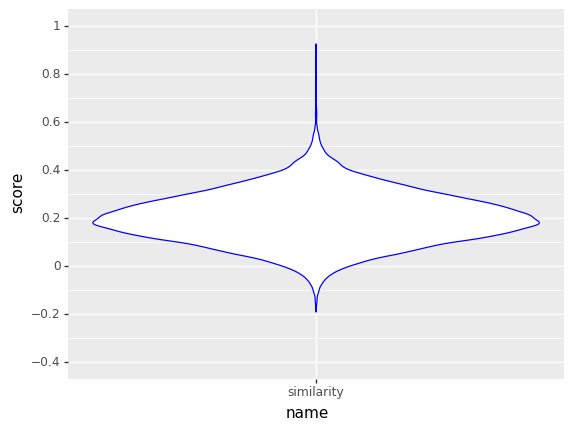

{<ggplot: (8760486708793)>}

In [30]:
#WARNING!  This produces a memory error on many out-of-the-box Docker configurations and will reset the notebook kernel.

#Uncomment if you have plenty of memory allocated and want to try running yourself.

#{
#    ggplot(comparisons[:50000], aes('name','score')) +
#    geom_violin(color='blue') + 
#    scale_y_continuous(limits=[-0.4,1.0], breaks=[-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0])
#}

## Listing 13.13

### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [13]:
import nmslib
# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = index.knnQuery(embeddings[25], k=10)
matches = [labels[phrases[idx]].lower() for idx in ids]
print(matches)

['bag', 'bag ratings', 'bag cover', 'bag liner', 'garbage bags', 'wag bags', 'bag cooking', 'airbag', 'paper bag', 'tea bags']


## Listing 13.14

In [14]:
from IPython.display import display,HTML
def print_labels(prefix,matches):
    display(HTML('<h4>Results for: <em>'+prefix+'</em></h4>'))
    for l,d in matches:
        if l in labels.keys():
            l = labels[l].lower()
        print(l + '\t' + str(d))
        
def semanticsuggest(query,k=20):
    matches = []
    embeddings = stsb.encode([query], convert_to_tensor=True)
    ids, distances = index.knnQuery(embeddings[0], k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = 1.0-distances[i]
        if dist>0.75:
            matches.append((text,dist))
    if not len(matches):
        matches.append((phrases[ids[1]],1.0-distances[1]))
    return matches

def autocomplete(prefix):
    matches = semanticsuggest(prefix)
    print_labels(prefix,matches)

In [15]:
autocomplete('mountain hike')

mountain hike	1.0
mountain hiking	0.9756486415863037
mountain trail	0.8470596075057983
mountain guides	0.787041962146759
mountain terrain	0.7799177765846252
mountain climbing	0.7756215333938599
mountain ridge	0.7680720686912537
winter hikes	0.7541309595108032


In [16]:
autocomplete('campfire')

campfire	0.9999998807907104
camp fire	0.9566245079040527
campfire impacts	0.9282976388931274
camping fuels	0.8655523061752319
camping stoves	0.8239544630050659
camp stove	0.7969686388969421
cooking fires	0.7753306031227112
campground	0.7744450569152832
fireplace	0.764971137046814
camping area	0.759650707244873
have camped	0.7553194761276245


In [17]:
autocomplete('dehyd')

dehydrated	0.941748857498169
dehydration	0.9317411184310913
rehydration	0.8525172472000122
dehydrator	0.8514857888221741
hydration	0.8362185955047607
hydrating	0.8358259201049805
rehydrating	0.8222475647926331
hydrated	0.8123505711555481
hydration pack	0.7883822917938232
hydration system	0.7768830060958862


In [18]:
autocomplete('compa')

comp	0.8632739782333374
compact	0.8295657634735107
compiled	0.8032785058021545
compost	0.7929490208625793
compass	0.7862531542778015
competitors	0.7782407999038696
competence	0.7651965618133545
compactor	0.7587991952896118
compare	0.7551054954528809


## Addendum: Bias Excercise
These cells enable exploration for detecting similarity/context bias that may exist in a model

In [19]:
def buildCandidateSet(cons):
    terms = [k for (k,v) in cons.items()]
    originals = []
    candidates = []
    scores = []
    for term in tqdm.tqdm(terms[0:1000]):
        labels = semanticsuggest(term,k=25)
        originals += [term]*len(labels)
        candidates += [l[0] for l in labels]
        scores += [l[1] for l in labels]
    pairs = pandas.DataFrame({'term':originals,'candidate':candidates,'score':scores})
    return pairs

In [20]:
pairs = buildCandidateSet(topcons)
pairs.to_csv('pairs.csv')

100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


In [21]:
#Compare a list of terms
def compare(terms):

    term_embeddings = stsb.encode(terms, convert_to_tensor=True)
    
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(terms)-1):
        for b in range(a+1, len(terms)):
            a_phrases.append(terms[a])
            b_phrases.append(terms[b])
            sim = STutil.pytorch_cos_sim(term_embeddings[a],term_embeddings[b])
            scores.append(float(sim))

    comparisons = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores,"name":"similarity"})
    comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
    return comparisons

In [22]:
#Gender-occupational bias example
#Note the similarity scores for gender and occupation 
compare(['man','woman','nurse practitioner','doctor'])

,phrase a,phrase b,score,name
0,nurse practitioner,doctor,0.488934,similarity
1,man,woman,0.280403,similarity
2,woman,nurse practitioner,0.179482,similarity
3,man,doctor,0.084211,similarity
4,woman,doctor,0.028788,similarity
5,man,nurse practitioner,-0.030063,similarity


## Addendum: Vector Space Visualization
This cell uses Principal Component Analysis (PCA) to reduce embeddings to 3 dimensions so they can be plotted in 3d.

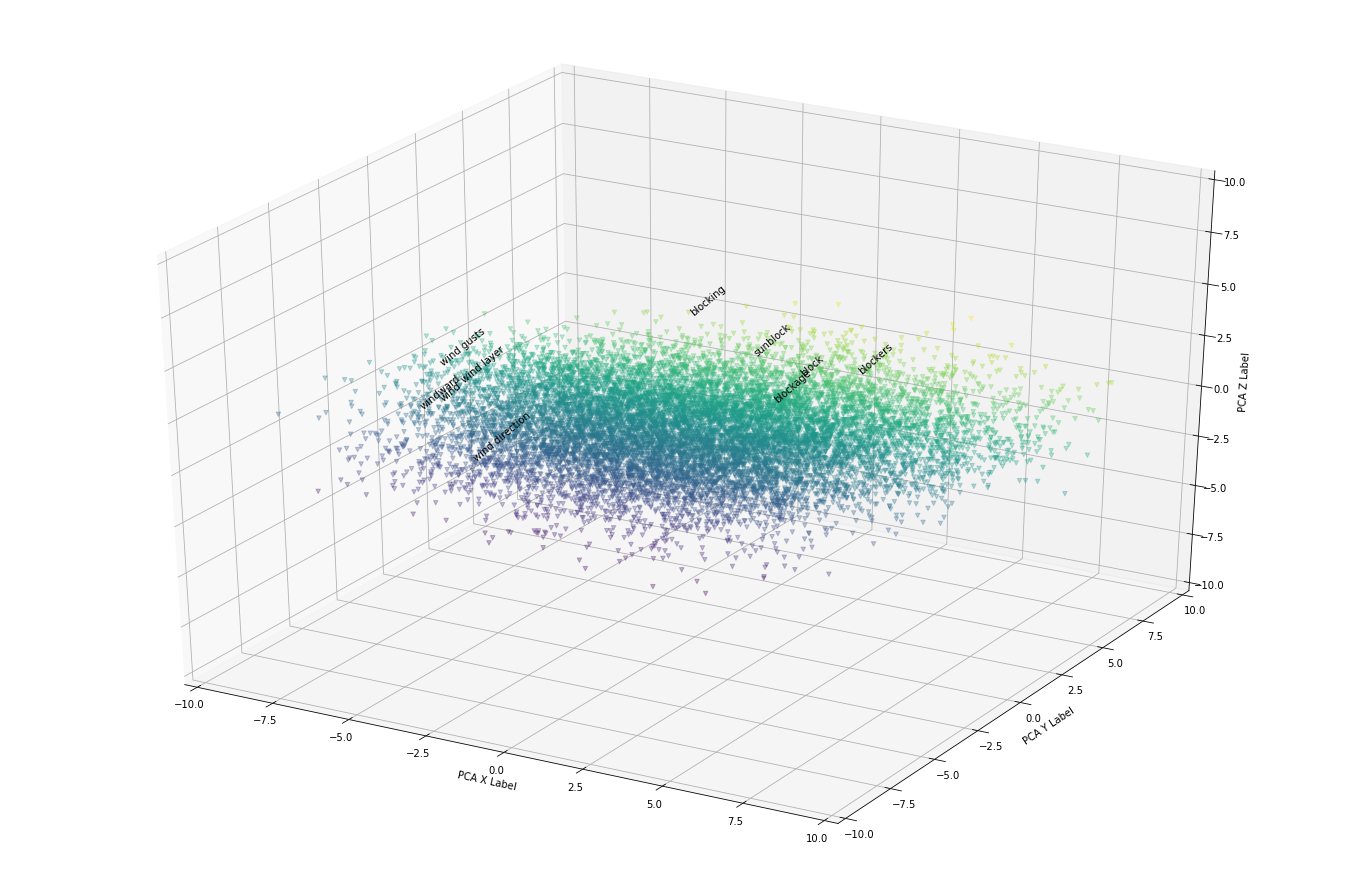

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = embeddings.numpy()
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = index.knnQuery(embeddings[100], k=5)
label_ids += [idx for idx in ids]
ids,_ = index.knnQuery(embeddings[505], k=5)
label_ids += [idx for idx in ids]
label_texts += [labels[phrases[idx]].lower() for idx in label_ids]
markers = ['v']*len(vectors)

components = pandas.DataFrame({
    'x': pca_data[:,0],
    'y': pca_data[:,1],
    'z': pca_data[:,2]
})

ax = plt.figure(figsize=(24,16)).add_subplot(projection='3d')
ax.scatter(
    components['x'].values, 
    components['y'].values, 
    c=components['y'].values, 
    marker='v', 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components['x'][i]
    y = components['y'][i]
    z = components['z'][i]
    zdir = 'y'
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel('PCA X Label')
ax.set_ylabel('PCA Y Label')
ax.set_zlabel('PCA Z Label')
plt.show()

## Addendum: Find topic vector centroids with KMeans

In [24]:
from torch import stack as  torch_stack
from sklearn.cluster import KMeans

def semanticnearest(embeddings,k=20):
    matches = []
    ids, distances = index.knnQuery(embeddings, k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = 1.0-distances[i]
        if dist>0.6:
            matches.append((ids[i],text,dist))
    if not len(matches):
        matches.append(([ids[1]],phrases[ids[1]],1.0-distances[1]))
    return matches

In [25]:
def findcentroids(embeddings,n_clusters=8,max_iter=300):
    centroids = []
    centroid_embeddings = []
    vectors = embeddings.numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=505, max_iter=max_iter).fit(vectors)
    for centroid in kmeans.cluster_centers_:
        matches = semanticnearest(centroid,k=5)
        centroids.append(matches[0])
        centroid_embeddings.append(embeddings[matches[0][0]])
        display(HTML('<h4>Results for: <em> centroid '+str(len(centroids)-1)+'</em></h4>'))
        for i,l,d in matches:
            if l in labels.keys():
                l = labels[l].lower()
            print(str(i) + '\t' + l + '\t' + str(d))
    
    return centroids,torch_stack(centroid_embeddings)

In [26]:
centroids,centroid_embeddings = findcentroids(embeddings,n_clusters=100,max_iter=50)

1109	sunlight	0.8945755958557129
157	light	0.8936781287193298
6549	lightness	0.8789409399032593
927	lightning	0.8714559078216553
11942	sun light	0.8621187806129456


8227	strangled	0.7928388118743896
8398	entangled	0.7781763076782227
2190	tangled	0.7628129124641418
3692	dangling	0.7303851246833801
11150	entanglement	0.7038062810897827


3822	slit	0.7796573638916016
3042	silk	0.7793006896972656
2275	se	0.7736002206802368
11253	sls	0.7612611055374146
4789	suv	0.7502987384796143


1403	garment	0.8344688415527344
6972	gadget	0.8163372874259949
8974	gaia gps	0.7990012168884277
2398	garage	0.783523440361023
9941	gpi	0.7816853523254395


5277	overloading	0.8073945641517639
11355	large	0.7859331369400024
2362	high	0.7810285091400146
12005	heighten	0.7763228416442871
3176	maximum	0.7605316638946533


6684	trail system	0.8547019362449646
28	trail	0.8218647241592407
8176	trails	0.8205459117889404
6527	trail map	0.8172569274902344
11621	trailing	0.8160126209259033


4911	documentation	0.7447240352630615
8806	conservancy	0.7263535857200623
1772	document	0.7057943344116211
496	reported	0.696448802947998
1603	understanding	0.6851192116737366


6763	contraction	0.7673501372337341
7600	crate	0.7651628255844116
7250	carbonate	0.7620643377304077
8033	consumables	0.7501769661903381
2484	contour	0.7477740049362183


2953	sea kayak	0.8261662721633911
9957	water boat	0.798089325428009
2188	sailboat	0.7827492952346802
7004	fishing kayak	0.7776674628257751
10464	scuba dive	0.7668651342391968


3381	molecules	0.7562896013259888
3134	montana	0.7388768792152405
10170	ammonium nitrate	0.7376934289932251
6978	mojave	0.732184886932373
9714	marlin	0.7270861268043518


7036	fl	0.8436286449432373
1967	flotation	0.8141059875488281
12336	fluorescent	0.8087085485458374
1677	flint	0.8083299398422241
2361	flavors	0.8044235706329346


8070	body core	0.7881053686141968
9864	body types	0.7598038911819458
7407	body temp	0.7525734901428223
6280	core body	0.7313453555107117
5759	body position	0.730890154838562


5537	telephone	0.863501250743866
3360	cellphone	0.8396388292312622
377	phone	0.8369314670562744
1747	cell phone	0.8305876851081848
11066	communication device	0.8283892273902893


6603	retirement	0.8169283866882324
50	end	0.8063843846321106
9333	ending	0.8029909729957581
7421	have ended	0.792854905128479
8975	firing	0.7910627722740173


1402	v	0.8634260296821594
5870	va	0.8502854704856873
1502	valve	0.8322284817695618
704	uv	0.8186381459236145
2139	van	0.8168848752975464


4850	penguin	0.7281611561775208
8219	pinnacle	0.7216882109642029
5794	polaris	0.7182856798171997
4849	peas	0.7127005457878113
3104	pistols	0.7110999822616577


10921	proper	0.8156235218048096
8285	prevalence	0.8113902807235718
2585	propose	0.7789950966835022
8118	preform	0.7518501877784729
4079	promise	0.7474579215049744


278	north	0.78727787733078
8967	recreational	0.7821844220161438
5496	creases	0.7794337868690491
287	emergency	0.7772157192230225
3848	north face	0.7726125717163086


69	ground	0.7888917326927185
5126	ground level	0.7868220210075378
9662	ground surface	0.7707705497741699
6778	ground cover	0.7539224624633789
8656	ground pad	0.7424023747444153


2865	gauge	0.7980409860610962
4663	gr	0.7946977615356445
12260	gander	0.7913389801979065
641	g	0.7726212739944458
10176	grapevine	0.7685146927833557


1928	h	0.85076504945755
10503	hutte	0.806161642074585
7088	hwy	0.7930694818496704
4827	hace	0.7886566519737244
11818	hasten	0.7859461307525635


1701	hiking trails	0.9123027324676514
11587	hiking paths	0.9040005207061768
3025	hiking trip	0.8879932165145874
93	hiking	0.8865604996681213
8955	hiking routes	0.8840516805648804


10704	tense	0.7947965860366821
11259	timeline	0.731303334236145
2746	condensing	0.7271862030029297
1696	lenses	0.7222676277160645
8	times	0.7205233573913574


1112	s	0.8179005980491638
9384	sc	0.796104371547699
6373	sa	0.7918481230735779
2800	sar	0.7868070602416992
9077	scenic	0.7683889269828796


2413	extension	0.8216473460197449
2098	e	0.8045477867126465
5884	expel	0.7905752658843994
8373	es	0.780689537525177
10636	engraved	0.7803674936294556


11542	dnt	0.8260440826416016
4547	dent	0.8259354829788208
1852	d	0.8254033923149109
7002	delorme	0.8210561871528625
9735	duo	0.8015967607498169


806	brake	0.6610455513000488
4903	braking	0.660443902015686
353	attacks	0.6266265511512756
6416	blockers	0.6257972121238708
9051	brake side	0.6256542801856995


80	ice	0.8512915968894958
3071	ice axes	0.8450204730033875
8369	icefall	0.8169555068016052
11032	ice box	0.7974570989608765
5862	ice cubes	0.7973520755767822


866	considerations	0.7790737152099609
6446	reconsider	0.7693690657615662
5079	speculation	0.7579906582832336
2633	confusion	0.7554357051849365
4080	interpretations	0.7551515102386475


1141	headlamp	0.735024631023407
8574	thumps	0.7089682221412659
2200	lamp	0.7073100805282593
3324	stump	0.6914098858833313
7500	lampreys	0.6874138116836548


2183	ii	0.7698532342910767
4185	nz	0.7482293844223022
1880	in	0.7358308434486389
2624	i	0.7172378897666931
3801	ie	0.7072279453277588


3400	rainfall	0.85353684425354
1997	weather conditions	0.8455760478973389
10245	weathering	0.8356996178627014
2697	weather forecast	0.8245867490768433
6840	weather reports	0.8213326930999756


513	man	0.7895769476890564
9213	mens	0.7717434167861938
2477	father	0.7499759197235107
8184	adult male	0.7322503328323364
1447	manner	0.7237081527709961


52	bears	0.8415214419364929
6637	bear boxes	0.8276795148849487
2355	bear bag	0.8223682641983032
6804	bear bangers	0.8057035207748413
1330	bear spray	0.8044456243515015


2602	n	0.8518831729888916
7539	ne	0.8314252495765686
4107	ny	0.7881286144256592
11971	nestled	0.7744513154029846
10901	verne	0.7719812393188477


10283	survival tool	0.8172825574874878
9037	survival rate	0.7804650068283081
6385	survivalist	0.7767894268035889
8836	rope handling	0.7696199417114258
8799	rope strength	0.7684511542320251


53	fire	0.9294146299362183
8855	fire risk	0.8624349236488342
9178	fire way	0.8529708385467529
8515	friction fires	0.8404302597045898
1404	firearm	0.8396852016448975


7466	blubber	0.8232579231262207
9204	rubble	0.8153637051582336
8988	bloqueurs	0.802986741065979
3958	blanc	0.7951823472976685
691	rubber	0.7910590767860413


11076	plastic sheet	0.7953799366950989
408	plastic	0.7789164781570435
8521	plateaus	0.7722117900848389
6894	polymer	0.7298401594161987
3020	posture	0.7295494079589844


901	water bottles	0.7900294661521912
12055	oxygen bottles	0.7857909202575684
6776	pop bottles	0.7823797464370728
6929	spray bottle	0.7797139286994934
9303	squeeze bottle	0.7790443897247314


2983	p	0.8567236661911011
9900	pipistrelle	0.8478866815567017
5761	pp	0.8367398977279663
4872	piston	0.8339190483093262
8382	prepping	0.8305877447128296


7828	air force	0.8570634722709656
3081	aircrafts	0.8507125377655029
95	air	0.8497235774993896
2723	airplanes	0.8485412001609802
8746	air exchange	0.8427417278289795


10466	handwashing	0.7953184843063354
11868	dishwashing	0.7926886081695557
1514	wipes	0.7841882705688477
10465	rinsing	0.7780656814575195
360	washing	0.7733072638511658


5	water	0.9330457448959351
9093	watering	0.9285187721252441
7458	water systems	0.9276186227798462
2929	water temperatures	0.8954266309738159
8322	water filtration	0.8950187563896179


1728	recovery	0.7974797487258911
3253	recoiling	0.7856552600860596
1364	recover	0.7713776230812073
2060	rescuer	0.767763078212738
7185	repack	0.7642086744308472


10391	backpack weights	0.8673977851867676
150	backpack	0.8270052671432495
5341	backpack straps	0.8164209723472595
3707	pack weight	0.7782858610153198
10376	pound pack	0.7762053608894348


76	heat	0.867373526096344
3259	heat source	0.8613738417625427
8423	reheat	0.860671877861023
9223	temperature conditions	0.8585717678070068
11873	preheating	0.8491771221160889


6103	sw	0.8472030162811279
493	swim	0.8377355933189392
10922	swift	0.8215003609657288
7221	swat	0.813248872756958
2836	swarms	0.8107367753982544


84	mountains	0.9452857375144958
11653	mountain region	0.9336071014404297
6987	mountain area	0.9167739152908325
5184	mountain national	0.915713906288147
7808	mountain project	0.9014525413513184


3471	concealed	0.7819129228591919
262	c	0.7813875675201416
9994	caverns	0.770060122013092
11531	cary	0.7629309892654419
6263	ccs	0.7594953775405884


18	keep	0.8885965347290039
570	maintain	0.830022931098938
7310	keep doing	0.8277988433837891
5366	have keeping	0.809525728225708
1951	help keep	0.8061468601226807


2606	relationship	0.8452835083007812
187	couple	0.8379209041595459
4838	couple years	0.8084498643875122
4754	couple times	0.7961342334747314
10514	couple things	0.7883810997009277


8310	ejected	0.8039317727088928
1512	extent	0.7920812368392944
2722	evolved	0.7913092374801636
10186	outward	0.7650128602981567
2413	extension	0.7593164443969727


10456	nice	0.8475553393363953
3099	cleaner	0.812013566493988
369	clean	0.8116486668586731
1261	clear	0.7936659455299377
1513	ease	0.787690281867981


539	f	0.8439687490463257
12051	fcrf	0.8199952840805054
7175	fusion	0.8065340518951416
8001	ferns	0.7848902940750122
3500	fist	0.783600926399231


1718	shotgun	0.843986988067627
742	guns	0.8410755395889282
6615	gunshot	0.825272798538208
10150	gun season	0.8124725818634033
7451	shotgun shells	0.8083924055099487


2660	dispersed	0.9087055921554565
3344	displaced	0.9051640033721924
5593	disregard	0.9017223715782166
7969	withdrawal	0.8911317586898804
1750	get rid	0.8871724605560303


8276	begs	0.8209500312805176
4410	banff	0.7956966757774353
11467	boast	0.7878835797309875
4257	beast	0.7665308713912964
10886	boofe	0.7599779963493347


3501	tethered	0.8182971477508545
24	tent	0.8066989779472351
8683	tent material	0.8062863945960999
8745	tent design	0.8040661811828613
7545	tent walls	0.802070140838623


5292	compact	0.824201226234436
1081	compress	0.7996229529380798
345	compass	0.7773452401161194
10502	compactor	0.7696640491485596
6117	compiled	0.7629557251930237


46	food	0.9173519015312195
7376	food items	0.9015787839889526
7067	food grade	0.8738784790039062
11180	food intake	0.8676683902740479
11722	food pack	0.8632336258888245


770	skiing	0.9050852060317993
9471	ski slope	0.8981409072875977
1557	skier	0.8764029741287231
9050	at skis	0.8711999654769897
153	skiing	0.8663368821144104


1439	l	0.8336722254753113
7223	laurel	0.8280676007270813
1414	lens	0.7976605296134949
5528	lukla	0.7912044525146484
10929	laos	0.7637960910797119


240	altitude	0.7160801291465759
12281	altitude data	0.7053009271621704
6679	atlas	0.6940217614173889
6959	ar	0.6787800192832947
8520	altitude changes	0.665091872215271


5610	camping area	0.9423543214797974
4416	camping sites	0.9389567971229553
10206	camping place	0.937701940536499
101	camping	0.9376334547996521
4735	camping spot	0.9286705851554871


8792	rab	0.7916947603225708
4254	robert	0.7884145379066467
5457	roaring	0.7800905108451843
12277	ro	0.7738733291625977
7849	rock type	0.7727413177490234


6570	walking shoes	0.8724969029426575
4594	walking boots	0.8168799877166748
1024	footwear	0.8026888966560364
3154	footpath	0.791033148765564
30	feet	0.790637731552124


758	lowering	0.8141896724700928
8259	lowering	0.8104305267333984
11847	undercut	0.8074735403060913
12012	underneath	0.8000808358192444
10980	substrate	0.7834247350692749


976	observe	0.8061666488647461
1233	o	0.7747920751571655
5426	o o	0.7631250619888306
5206	logo	0.756060779094696
8058	ingestion	0.752757728099823


60	climbing	0.9186282753944397
4160	climbing wall	0.8905673027038574
6205	climbing grades	0.8849503993988037
8884	climbing style	0.8793357014656067
9219	climbing trip	0.8760182857513428


332	training	0.8076972365379333
9500	training courses	0.8058733344078064
8551	training program	0.8009703159332275
11182	training sessions	0.7906038761138916
8926	has taught	0.7606878280639648


442	moisture	0.7943164110183716
7202	moisture content	0.7901343703269958
10628	muscle power	0.7759458422660828
439	muscles	0.774764358997345
5977	muscle mass	0.7741833925247192


257	m	0.8523173928260803
542	mm	0.8503137230873108
1528	mid	0.7983829379081726
9545	midway	0.7727423906326294
6851	multi	0.7647188901901245


135	winter	0.955249547958374
7724	winter seasons	0.9391878247261047
4223	winter conditions	0.9373760223388672
11371	winter weather	0.9288967847824097
6105	winter months	0.8917027711868286


183	safety	0.9462103843688965
5101	safety precaution	0.9408590793609619
9273	safety aspect	0.9349850416183472
6378	safety measures	0.9286904335021973
8175	safety factor	0.9219131469726562


8189	diffusion	0.8313100337982178
6206	aversion	0.803641676902771
2970	transmission	0.7846842408180237
6899	diffuse	0.7840640544891357
12086	transducers	0.7819963693618774


1128	t	0.8745420575141907
8745	tent design	0.8600553870201111
8683	tent material	0.8564537167549133
24	tent	0.852789044380188
11022	tso	0.8463925123214722


5319	ve slept	0.7964235544204712
2313	retreating	0.7936437726020813
62	sleeping	0.7931964993476868
5775	silence	0.7907707691192627
10115	sleeping area	0.7890030741691589


5620	viewing	0.8385904431343079
4103	insight	0.8312902450561523
9587	viewer	0.8278335928916931
6219	watching	0.8003485202789307
7240	eyesight	0.79594886302948


3472	k	0.8099653720855713
7389	ken	0.7838228940963745
11750	karen	0.7529890537261963
3358	trekkers	0.7450528144836426
4272	kettle	0.7402283549308777


4355	polypro	0.8542211651802063
1441	polyester	0.8364450335502625
12116	polypro top	0.8329082727432251
2641	polypropylene	0.8191803693771362
4731	polyurethane	0.8097794055938721


41	start	0.9020993113517761
4170	get started	0.8878239393234253
4157	have started	0.8872624635696411
578	begins	0.886286199092865
1574	beginning	0.8847512006759644


8092	payment	0.7807206511497498
7334	price tag	0.766392707824707
610	price	0.73020339012146
11647	refund	0.7239673137664795
3980	discounting	0.7172304391860962


898	b	0.8747377991676331
11190	ba	0.8448811769485474
3410	barb	0.838390588760376
6818	basal	0.8246976137161255
11862	basalt	0.8143417835235596


4283	st	0.8343465924263
4399	stern	0.776405394077301
7028	stewart	0.7748077511787415
11892	steck	0.7541282176971436
1123	stings	0.7380426526069641


628	cooking	0.8307031393051147
11580	cooking time	0.8261282444000244
10797	cooking area	0.8237627148628235
2947	cooker	0.8095831871032715
374	cook	0.7956139445304871


4317	union	0.7325165271759033
160	group	0.7277171611785889
9886	groupings	0.7221049070358276
4549	group member	0.7182799577713013
12063	family groups	0.7119659185409546


1396	r	0.8298084735870361
721	re	0.8224856853485107
4089	reps	0.779636800289154
2665	residue	0.7741425037384033
12307	reserved	0.7725980281829834


11151	get sucked	0.7569566965103149
613	trouble	0.7561292052268982
5130	shame	0.7497237324714661
2184	distress	0.7375166416168213
8607	bear problems	0.7324693202972412


2079	has got	0.7699882388114929
2173	had become	0.7666144371032715
5495	have occurred	0.747438371181488
6860	go getting	0.7296329140663147
8318	makes getting	0.7285885810852051


881	have had	0.8142198324203491
0	have	0.8061336874961853
11959	remember having	0.8038045763969421
6587	seen have	0.7971214652061462
11296	have seen have	0.7860366106033325


255	rescue	0.8623611927032471
8199	rescue situations	0.8488844037055969
9058	rescue work	0.834502100944519
5733	rescue operation	0.8243423700332642
4987	rescue service	0.8145252466201782


2033	wilderness area	0.8640120029449463
309	wilderness	0.8541505336761475
6035	wildland	0.8489030003547668
10394	wild country	0.8461509943008423
12293	wildlife habitat	0.8403773307800293


205	increased	0.8650597333908081
8363	revised	0.8553248643875122
947	advise	0.8441895842552185
6567	increments	0.834561824798584
3651	enhance	0.8065826892852783


2245	w	0.8538217544555664
5826	wa	0.8396890163421631
11220	wy	0.824282705783844
802	west	0.8225890398025513
12166	wren	0.8188945055007935


1538	spine	0.8703018426895142
11135	sp	0.8439285159111023
3987	spices	0.8427361249923706
9668	spasm	0.8098306655883789
2811	spitting	0.8096532225608826


2182	coconut	0.8104767799377441
5081	cocoon	0.8012444972991943
6184	coke	0.7782483696937561
10635	coconut shell	0.7719354033470154
3821	colonies	0.7572178840637207


4487	tree branches	0.8667088150978088
61	tree	0.8665449619293213
9533	trees limbs	0.8511949777603149
9226	tree cover	0.850333571434021
12089	tree stumps	0.8450928926467896


10932	geotagged	0.846355140209198
10019	geotags	0.8072090744972229
2885	georgia	0.8070176839828491
3883	genera	0.8049847483634949
6004	noggins	0.7962630391120911


59	snow	0.9354915022850037
9459	snow level	0.9330683350563049
4232	snow conditions	0.8951126933097839
10811	snow line	0.8945883512496948
3809	snowfall	0.8922398090362549


In [27]:
print(centroids)
print(centroid_embeddings)

[(1109, 'sunlight', 0.8945755958557129), (8227, 'strangle', 0.7928388118743896), (3822, 'slit', 0.7796573638916016), (1403, 'garment', 0.8344688415527344), (5277, 'overload', 0.8073945641517639), (6684, 'trail system', 0.8547019362449646), (4911, 'documentation', 0.7447240352630615), (6763, 'contraction', 0.7673501372337341), (2953, 'sea kayak', 0.8261662721633911), (3381, 'molecule', 0.7562896013259888), (7036, 'fl', 0.8436286449432373), (8070, 'body core', 0.7881053686141968), (5537, 'telephone', 0.863501250743866), (6603, 'retirement', 0.8169283866882324), (1402, 'v', 0.8634260296821594), (4850, 'penguin', 0.7281611561775208), (10921, 'proper', 0.8156235218048096), (278, 'north', 0.78727787733078), (69, 'ground', 0.7888917326927185), (2865, 'gauge', 0.7980409860610962), (1928, 'h', 0.85076504945755), (1701, 'hiking trail', 0.9123027324676514), (10704, 'tense', 0.7947965860366821), (1112, 's', 0.8179005980491638), (2413, 'extension', 0.8216473460197449), (11542, 'dnt', 0.826044082641

In [28]:
from sentence_transformers import util as STutil
similarities = STutil.pytorch_cos_sim(centroid_embeddings, centroid_embeddings)
print('The shape of the resulting similarities:',similarities.shape)

The shape of the resulting similarities: torch.Size([100, 100])


### KMeans Topic distribution

This cell below shows good distribution of similarity scores for our topics.

In [29]:
import pandas

a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(centroids[a][1])
        b_phrases.append(centroids[b][1])
        scores.append(float(similarities[a][b]))

df = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores})
df.sort_values(by=["score"],ascending=False,ignore_index=True)

,phrase a,phrase b,score
0,rab,r,0.748148
1,gauge,geotagge,0.741036
2,tether,t,0.732801
3,winter,snow,0.719569
4,water bottle,water,0.708768
...,...,...,...
4945,sea kayak,man,-0.145497
4946,camping area,t,-0.173272
4947,air force,walking shoe,-0.175434
4948,have sleep,start,-0.190825


Up next: [Semantic Search with Dense Vector Embeddings](4.semantic-search.ipynb)